<a href="https://colab.research.google.com/github/AlyW8/Data-Science/blob/main/Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)

aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=5, column='diff_TminusE', value=diff_TminusE)

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu=2)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu=2)
    μ_nu = pm.StudentT('μ_nu', mu = 0, sigma = 10, nu=2)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  nu=μ_nu,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', sigma = 10, nu=μ_nu,
                      dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                  nu=μ_nu,
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

#gemini used

In [ ]:
with pm.Model(coords=aa_coords) as cs_hn_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_hn = pm.sample()

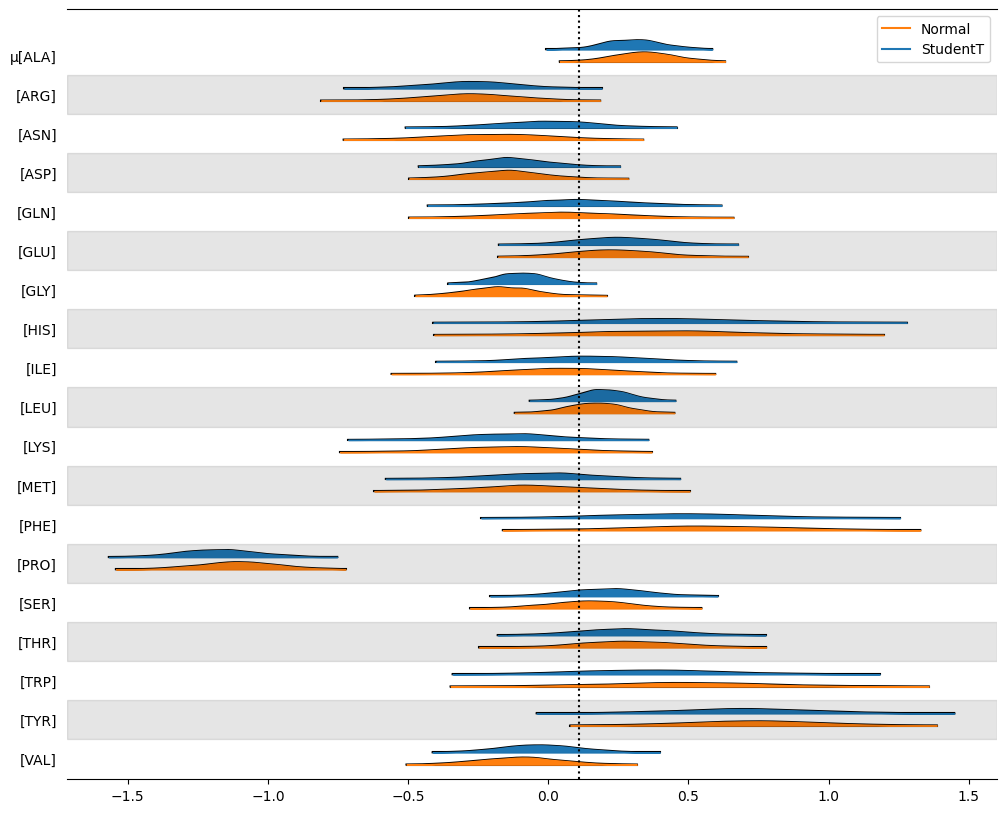

In [5]:
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_cs_h, idata_cs_hn], kind="ridgeplot",
                      model_names=['StudentT','Normal'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

- The student T model seems to fit the data better

Output()

<Axes: xlabel='y'>

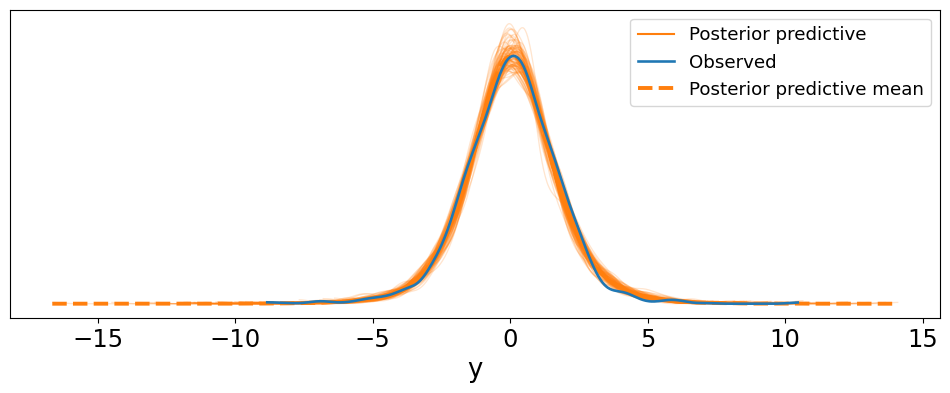

In [6]:
#student T model
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Output()

<Axes: xlabel='y'>

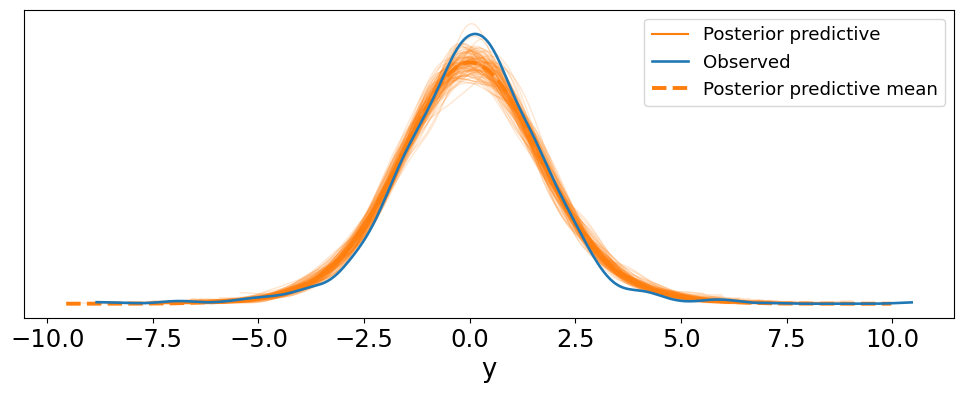

In [7]:
#Normal Model
pm.sample_posterior_predictive(idata_cs_hn, model=cs_hn_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_hn, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [48]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'}) #Turns the position column into a categorical variable

#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}


In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:


    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

- The non-hierarchical has better r hat values because fewer are over 1.1. The only r hat value over 1.1 is μ_p for GK.
- The plot traces honestly look pretty similar, but the non- hierarchical has black vertical lines that aren't in the hierarchical model

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

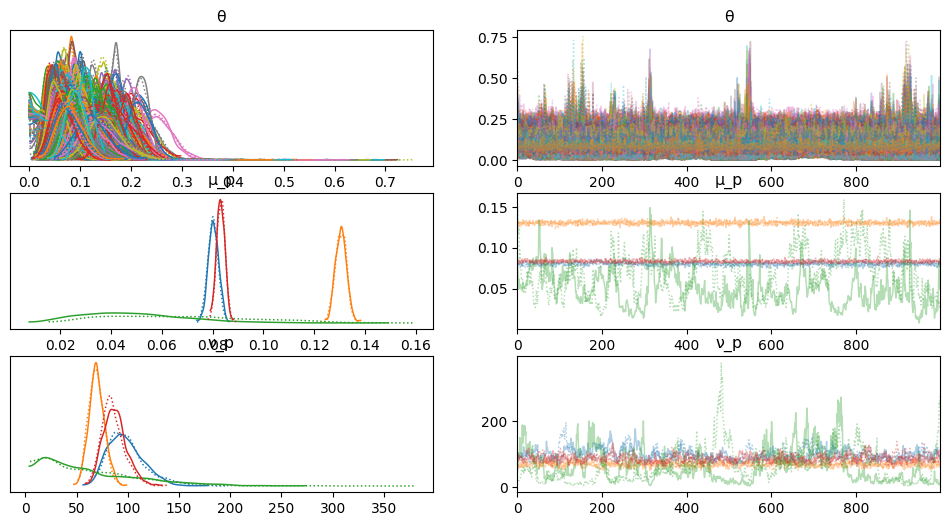

In [10]:
az.plot_trace(idata_sccr)

In [11]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.003 1.0 1.005 1.001 ... 1.0 0.9997 1.002
    μ_p      (pos) float64 32B 1.008 1.0 1.114 1.002
    ν_p      (pos) float64 32B 1.045 1.01 1.021 1.007

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

- They turned out pretty similarly. There aren't any significant differences as far as I can tell.

array([<Axes: >], dtype=object)

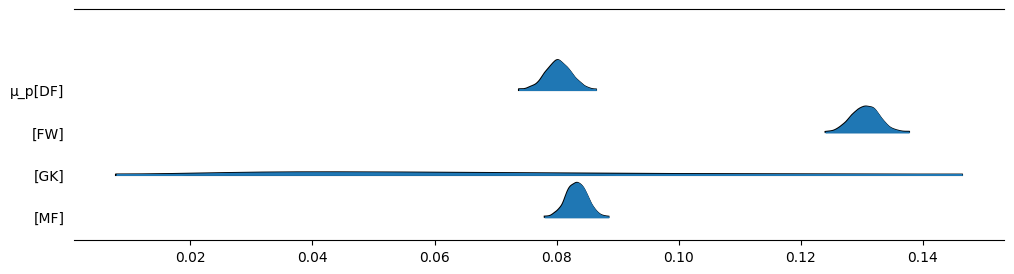

In [12]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [94]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [100]:
sccr_data_noGK = sccr_data.query('position != "GK"')
sccr_data_noGK.position = sccr_data_noGK.position.cat.remove_unused_categories()
sccr_data_noGK

/tmp/ipython-input-2917106575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sccr_data_noGK.position = sccr_data_noGK.position.cat.remove_unused_categories()


,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [101]:

pos_idx_noGK = sccr_data_noGK.position.cat.codes.values
pos_codes_noGK = sccr_data_noGK.position.cat.categories
sccr_coords_noGK = {"pos": pos_codes_noGK}

In [102]:
sccr_coords_noGK

{'pos': Index(['DF', 'FW', 'MF'], dtype='object')}

In [ ]:
with pm.Model(coords = sccr_coords_noGK) as sccr_model_noGK:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_noGK], nu = ν_p[pos_idx_noGK])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_noGK.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_noGK.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_noGK = pm.sample(target_accept = 0.95)

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

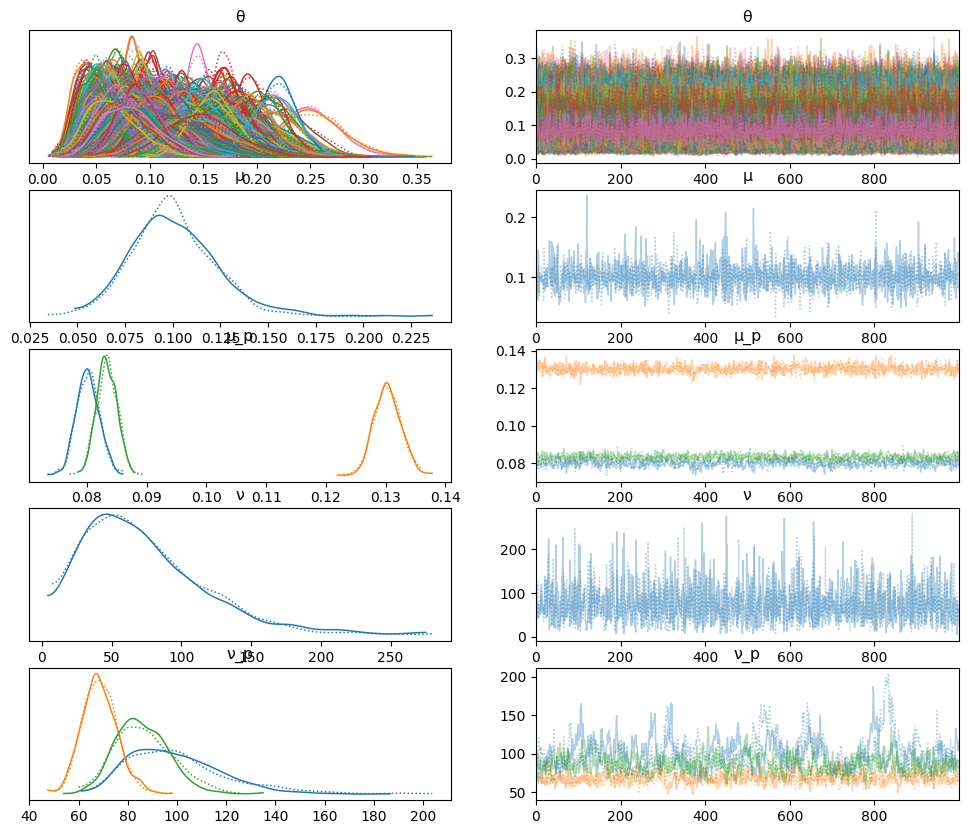

In [107]:
az.plot_trace(idata_sccr_noGK)

In [108]:
az.rhat(idata_sccr_noGK)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 0.9997 1.001 1.0 ... 0.9996 1.001 1.002
    μ        float64 8B 1.003
    μ_p      (pos) float64 24B 1.001 1.0 1.0
    ν        float64 8B 0.9998
    ν_p      (pos) float64 24B 1.038 1.003 1.006

array([<Axes: >], dtype=object)

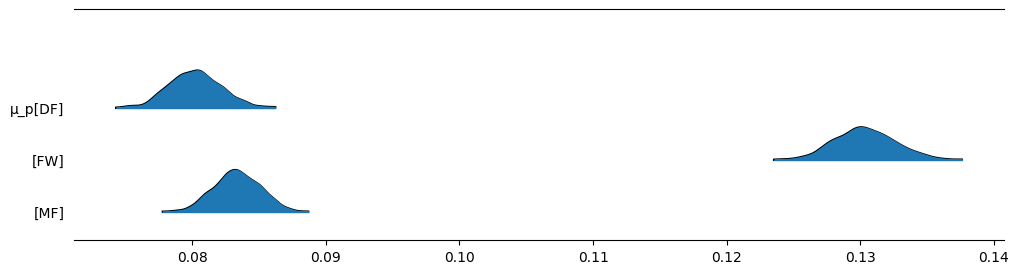

In [109]:
az.plot_forest(idata_sccr_noGK, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?


The one without the goalkeepers was easier for pymc to process. By dropping GKs, we lose information about the GKs, but we improve information about the other positions because they aren't as skewed by the variation in the GK data.